In [1]:
from capstonfire_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchmetrics.classification import Precision, Recall, F1Score

from torchmetrics.classification import AUROC, PrecisionRecallCurve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sn

# One final experiment - keeping aspect ratio with center cropping

In [2]:
def train_model(model: torch.nn.Module,criterion, optimizer, 
                models_folder_path: str, model_filename: str, 
                num_epochs: int, 
                train_loader: DataLoader, val_loader: DataLoader, 
                epoch_checkpoints: int = 0):
    

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    if epoch_checkpoints < 1:
        print("Checkpoints smaller than 1. Only the final model will be saved.")

    model = model.to(device)
    criterion = criterion.to(device)

    history = {
        "avg_train_loss_list": [],
        "train_accuracy_list": [],
        "avg_val_loss_list": [],
        "val_accuracy_list": []
    }

    start_range = 0

    hist_file_path = os.path.join(models_folder_path, model_filename + '.json')
    
    # Retrieve model if it was already trained. The state loaded will be that of the last epoch.
    if model_filename + '.pt' in os.listdir(models_folder_path):
        model.load_state_dict(torch.load(os.path.join(models_folder_path, model_filename +'.pt')))
        
        with open(hist_file_path, 'r') as json_file:
            history = json.load(json_file)

        # If num_epochs is equal or lower to the epochs of a previously trained model, skip training. Else continue training
        if len(history["avg_train_loss_list"]) >= num_epochs:
            return history
        else:
            start_range = len(history["avg_train_loss_list"])

    # if model was never trained, enter loop. If asking for more epochs, start from where model was left off
    for epoch in tqdm(list(range(start_range, num_epochs))):
        model.train()

        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward
            loss = criterion(outputs, labels)  # calculate loss
            loss.backward()  # backward
            optimizer.step()  # optimize

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
            
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)

                _, predicted_val = torch.max(outputs_val, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

                val_loss += loss_val.item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history["avg_train_loss_list"].append(avg_train_loss)
        history["train_accuracy_list"].append(train_accuracy)
        history["avg_val_loss_list"].append(avg_val_loss)
        history["val_accuracy_list"].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        # Do not save if there is no indication to store intermediate models or if it is the last iteration of the training loop
        if epoch_checkpoints < 1:
            continue

        # Store models after every epoch_checkpoints number of epochs
        if (epoch + 1) % epoch_checkpoints == 0 and epoch > 0:
            path_to_model_folder = os.path.join(models_folder_path, model_filename)

            if not os.path.exists(path_to_model_folder):
                os.makedirs(path_to_model_folder, exist_ok=True)
                
            torch.save(model.state_dict(), os.path.join(path_to_model_folder, "epoch_" + str(epoch + 1) + '.pt'))

    print('Finished Training')

    # save model at last epoch
    torch.save(model.state_dict(), os.path.join(models_folder_path, model_filename + '.pt'))

    # Write history dictionary to a JSON file
    with open(hist_file_path, 'w+') as json_file:
        json.dump(history, json_file)

    return history

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # to capture basic patterns from the image
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# to capture basic patterns from the previous patterns (results in capturing more complex patterns from the original image)
        self.fc1 = nn.Linear(74420, 50)
        self.fc2 = nn.Linear(50, 2) # DNN > WNN; also 2 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 74420)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

In [4]:
def calculate_epoch_metrics(models_path, model_name, test_loader):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    intermediate_model = SimpleCNN().to(device)

    epoch_metrics = {}

    for dirpath, _, filenames in os.walk(os.path.join(models_path, model_name)):
        for model_filename in tqdm(filenames):
            intermediate_model.load_state_dict(torch.load(os.path.join(dirpath, model_filename)))

            recall = Recall(task='multiclass',num_classes=2).to(device)
            precision = Precision(task='multiclass',num_classes=2).to(device)
            f1 = F1Score(task='multiclass',num_classes=2).to(device)

            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = intermediate_model(inputs)  # forward
                    #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
                    predictions = torch.argmax(outputs, dim=1)

                    recall.update(predictions, labels)
                    precision.update(predictions, labels)
                    f1.update(predictions, labels)

            precision_value = precision.compute()
            recall_value = recall.compute()
            f1_value = f1.compute()

            epoch_metrics[model_filename] = {
                "Precision": precision_value, 
                "Recall": recall_value, 
                "F1Score": f1_value
                }
    
    return epoch_metrics

In [5]:
def sort_metrics(metrics_dict):
    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df = df.map(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
    df = df.rename(index=lambda x: int(x.split('_')[1].split('.')[0]))
    return df.sort_index()

In [6]:
def get_confusion_matrix(model, loader):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    model = model.to(device)

    predictions_array = []
    labels_array = []
    with torch.no_grad():
        for data in tqdm(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # forward
            #predicted_binary = (torch.sigmoid(outputs) > 0.5).float()
            predictions = torch.argmax(outputs, dim=1)
            for pred_value in predictions.cpu().numpy():
                predictions_array.append(pred_value)
            
            # Append individual label values to the array
            for label_value in labels.cpu().numpy():
                labels_array.append(label_value)
    
    return predictions_array, labels_array

In [7]:
base_path = "C:\\Users\\johnn\\Desktop\\Repos\\Capstonfire"
full_dataset_path = os.path.join(base_path, "new_full_dataset")
test_dataset_path = os.path.join(base_path, "test dataset")

In [8]:
desired_height = 640 #aspect ratio 16:9
desired_width = 256

transform_crop = transforms.Compose([
    transforms.CenterCrop(desired_height),
    transforms.Resize(desired_width),#int(desired_height * (img.width / img.height)))),
    transforms.ToTensor()
])

In [9]:
dataset_crop = FireDataset(full_dataset_path, transform_crop)

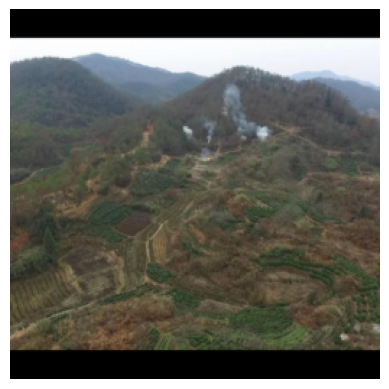

In [10]:
img, _ = dataset_crop[0]

# Convert the PyTorch tensor to a NumPy array and permute dimensions if necessary
img_np = img.permute(1, 2, 0).numpy()

# Display the image using Matplotlib
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [11]:
crop_train_loader, crop_val_loader, crop_test_loader = split_dataset_into_dataloaders(dataset_crop, 50, 0.7, 0.2, 0.1)

In [12]:
test_loader = DataLoader(FireDataset(test_dataset_path, transform_crop), 50, False)

In [13]:
crop_model = SimpleCNN()

In [14]:
crop_model_name = "dummy_cnn_crop"

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(crop_model.parameters(), lr=0.0003, momentum=0.9)

In [16]:
crop_history = train_model(crop_model, criterion, optimizer, os.path.join(base_path, "trained_models"), crop_model_name, 50, crop_train_loader, crop_val_loader, 2)

CUDA is available. Using GPU.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6896, Train Accuracy: 0.4983, Validation Loss: 0.6840, Validation Accuracy: 0.5007
Epoch [2/50], Train Loss: 0.6698, Train Accuracy: 0.6287, Validation Loss: 0.6488, Validation Accuracy: 0.6741
Epoch [3/50], Train Loss: 0.6089, Train Accuracy: 0.6846, Validation Loss: 0.5711, Validation Accuracy: 0.6994
Epoch [4/50], Train Loss: 0.5416, Train Accuracy: 0.7133, Validation Loss: 0.5263, Validation Accuracy: 0.6951
Epoch [5/50], Train Loss: 0.5008, Train Accuracy: 0.7204, Validation Loss: 0.4974, Validation Accuracy: 0.7132
Epoch [6/50], Train Loss: 0.4825, Train Accuracy: 0.7404, Validation Loss: 0.5002, Validation Accuracy: 0.7247
Epoch [7/50], Train Loss: 0.4841, Train Accuracy: 0.7431, Validation Loss: 0.4788, Validation Accuracy: 0.7247
Epoch [8/50], Train Loss: 0.4638, Train Accuracy: 0.7526, Validation Loss: 0.4656, Validation Accuracy: 0.7601
Epoch [9/50], Train Loss: 0.4504, Train Accuracy: 0.7623, Validation Loss: 0.4705, Validation Accuracy: 0.7536
E

In [17]:
crop_epoch_metrics = calculate_epoch_metrics(base_path, crop_model_name, test_loader)
crop_epoch_metrics = sort_metrics(crop_epoch_metrics)
best_checkpoint = crop_epoch_metrics['Precision'].idxmax()
best_checkpoint

CUDA is available. Using GPU.


  0%|          | 0/25 [00:00<?, ?it/s]

36

In [18]:
crop_model_best = SimpleCNN()
crop_model_best.load_state_dict(torch.load(os.path.join(base_path, crop_model_name, "epoch_" + str(best_checkpoint) + ".pt")))

<All keys matched successfully>

In [19]:
crop_best_predictions, test_labels = get_confusion_matrix(crop_model_best, test_loader)
crop_best_model_cm = confusion_matrix(crop_best_predictions, test_labels)
crop_best_model_cm

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

array([[ 859,  435],
       [ 223, 1479]], dtype=int64)

<Axes: >

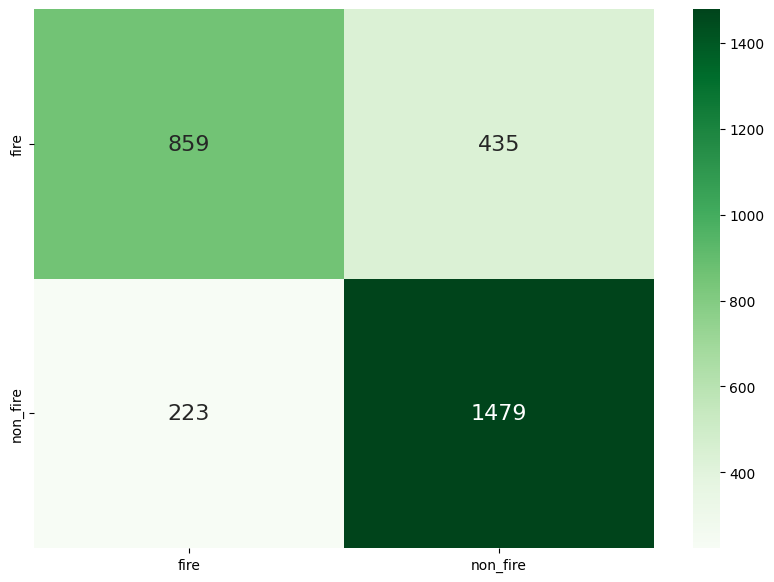

In [20]:
df_cm = pd.DataFrame(crop_best_model_cm, index = ['fire', 'non_fire'],
                  columns = ['fire', 'non_fire'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 16})

In [21]:
precision = precision_score(test_labels, crop_best_predictions)
print("Precision: ", precision)
recall = recall_score(test_labels, crop_best_predictions)
print('Recall: ', recall)
f1 = f1_score(test_labels, crop_best_predictions)
print('F1 Score: ', f1)

Precision:  0.8689776733254995
Recall:  0.7727272727272727
F1 Score:  0.8180309734513275


In [22]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [30]:
custom_test_loader = DataLoader(FireDataset(os.path.join(base_path, "test dataset"), transform), 50, False)

In [24]:
first_model_name = "dummy_cnn"
first_model_best = SimpleCNN()
first_model_best.load_state_dict(torch.load(os.path.join(base_path, "trained_models", first_model_name, "epoch_" + str(44) + ".pt")))
first_best_predictions, test_labels = get_confusion_matrix(first_model_best, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

In [25]:
full_model_name = "dummy_cnn_full_dataset"
full_model_best = SimpleCNN()
full_model_best.load_state_dict(torch.load(os.path.join(base_path, "trained_models", full_model_name, "epoch_24.pt")))
full_best_predictions, test_labels = get_confusion_matrix(full_model_best, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

In [31]:
full_model_weighted_name = "dummy_cnn_full_dataset_weighted"
full_model_weighted = SimpleCNN()
full_model_weighted.load_state_dict(torch.load(os.path.join(base_path, "trained_models", full_model_weighted_name + ".pt")))
full_weighted_predictions, test_labels = get_confusion_matrix(full_model_weighted, custom_test_loader)

CUDA is available. Using GPU.


  0%|          | 0/60 [00:00<?, ?it/s]

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

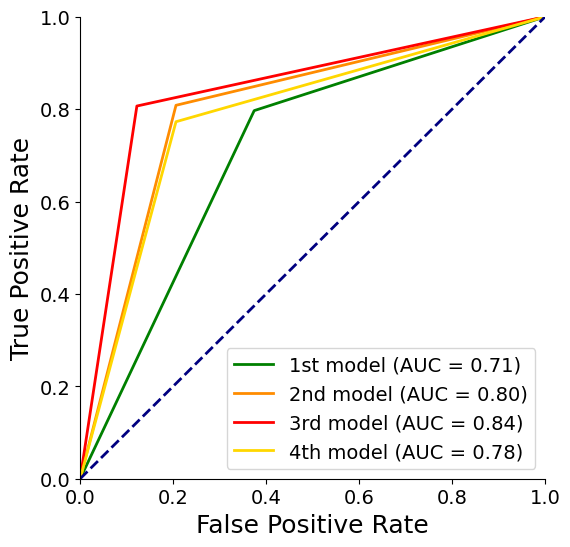

In [28]:
fpr_first, tpr_first, thresholds = roc_curve(test_labels, first_best_predictions)
fpr_full, tpr_full, thresholds = roc_curve(test_labels, full_best_predictions)
fpr_weighted, tpr_weighted, thresholds = roc_curve(test_labels, full_weighted_predictions)
fpr_crop, tpr_crop, thresholds = roc_curve(test_labels, crop_best_predictions)

# Calculate AUC
first_roc_auc = auc(fpr_first, tpr_first)
full_roc_auc = auc(fpr_full, tpr_full)
weighted_roc_auc = auc(fpr_weighted, tpr_weighted)
crop_roc_auc = auc(fpr_crop, tpr_crop)
# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr_first, tpr_first, color='green', lw=2, label=f'1st model (AUC = {first_roc_auc:.2f})')
plt.plot(fpr_full, tpr_full, color='darkorange', lw=2, label=f'2nd model (AUC = {full_roc_auc:.2f})')
plt.plot(fpr_weighted, tpr_weighted, color='red', lw=2, label=f'3rd model (AUC = {weighted_roc_auc:.2f})')
plt.plot(fpr_crop, tpr_crop, color='gold', lw=2, label=f'4th model (AUC = {crop_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

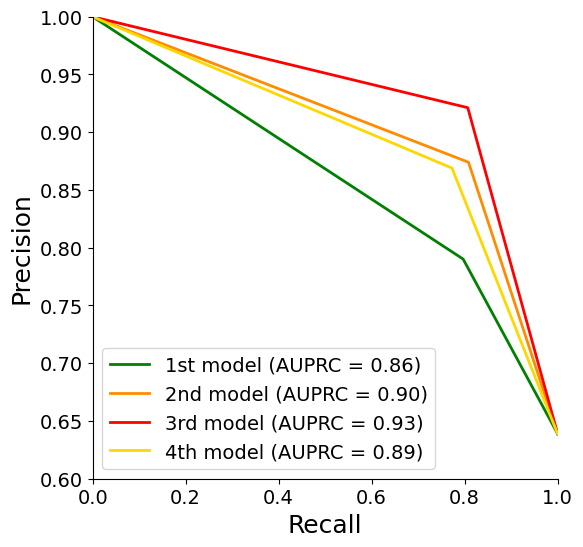

In [29]:
# Calculate PR curve
first_precision, first_recall, _ = precision_recall_curve(test_labels, first_best_predictions)
full_precision, full_recall, _ = precision_recall_curve(test_labels, full_best_predictions)
weighted_precision, weighted_recall, _ = precision_recall_curve(test_labels, full_weighted_predictions)
crop_precision, crop_recall, _ = precision_recall_curve(test_labels, crop_best_predictions)

first_auprc = auc(first_recall, first_precision)
full_auprc = auc(full_recall, full_precision)
weighted_auprc = auc(weighted_recall, weighted_precision)
crop_auprc = auc(crop_recall, crop_precision)

# Plot PR curve
plt.figure(figsize=(6,6))
plt.plot(first_recall, first_precision, color='green', lw=2, label=f'1st model (AUPRC = {first_auprc:.2f})')
plt.plot(full_recall, full_precision, color='darkorange', lw=2, label=f'2nd model (AUPRC = {full_auprc:.2f})')
plt.plot(weighted_recall, weighted_precision, color='red', lw=2, label=f'3rd model (AUPRC = {weighted_auprc:.2f})')
plt.plot(crop_recall, crop_precision, color='gold', lw=2, label=f'4th model (AUPRC = {crop_auprc:.2f})')
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.xlim([0, 1])
plt.ylim([0.6, 1.0])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='lower left', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, len(first_recall)-2)
plt.show()

In [32]:
transform_video = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.to(device))
])